The goal of this work is to study different gradient boosting methods and choose the best of them. Also, we are going to set parameters of these methods and see how it improves them.

## EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("Customer Churn.csv")
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
def print_probabilities(column_name):
    for i in df[column_name].unique():
        saved = df.loc[df[column_name] == i]['Stay'].sum()
        total = df.loc[df[column_name] == i].shape[0]
        print(str(i) + ": " + str(saved/total) + " (" + 
             str(saved) + " of " + str(total) + ")")

In [4]:
len(df['customerID'].unique()), df.shape

(7043, (7043, 21))

customerID is unique identification number of a customer. It is absolutely useless in our analysis, so we can remove it. Note that our goal parameter is 'Churn'

In [5]:
df.drop(['customerID'], axis=1, inplace=True)
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

We have no missed fields in our dataset. Sweet. Let us transform Churn parameter from {Yes, No} to {1, 0} to make it have opportunity to work with it as with boolean variable (calculate mean and sum for instance)

In [7]:
df['Stay'] = df['Churn'].map({'No': 1, 'Yes': 0})
df.drop(['Churn'], axis=1, inplace=True)
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,1
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0


In [8]:
print_probabilities('gender')

Female: 0.7307912844036697 (2549 of 3488)
Male: 0.7383966244725738 (2625 of 3555)


Probabilities to stay as a customer for both genders are approximately the same. It looks that gender does not influence on the decision

In [9]:
print_probabilities('SeniorCitizen')

0: 0.763938315539739 (4508 of 5901)
1: 0.5831873905429071 (666 of 1142)


Probailities are different, Senior Citizens stay customers rarely. This is important feature

In [10]:
print_probabilities('Partner')

Yes: 0.8033509700176367 (2733 of 3402)
No: 0.6704202142268607 (2441 of 3641)


Probailities are difeerent, Partners stay customers often. This is important feature

In [11]:
print_probabilities('Dependents')

No: 0.6872085951753497 (3390 of 4933)
Yes: 0.8454976303317535 (1784 of 2110)


Probailities are different, Dependents stay customers often. This is important feature

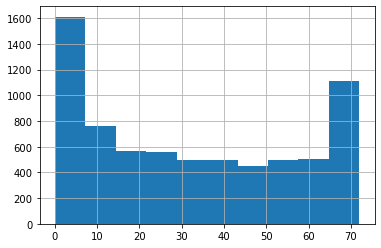

In [12]:
df['tenure'].hist()

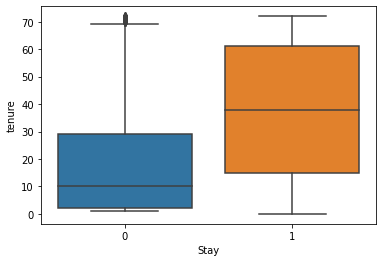

In [13]:
sns.boxplot (data = df, x = 'Stay', y = 'tenure')

We have significant difference between tenure value in two groups. If a customer has longer tenure it means he/she has more chances to stay as a customer. Also, importnat feature

In [14]:
print_probabilities('PhoneService')

No: 0.750733137829912 (512 of 682)
Yes: 0.7329036315044805 (4662 of 6361)


It seems there is no big difference between chances here. Phone service is not effective I think, because it gives 2% less chance for customer to stay

In [15]:
df['MultipleLines'].unique()

array(['No phone service', 'No', 'Yes'], dtype=object)

In [16]:
len(df.loc[(df['PhoneService'] == "Yes") & (df['MultipleLines'] == 'No phone service')]), len(df.loc[(df['PhoneService'] == "No") & (df['MultipleLines'] != 'No phone service')])

(0, 0)

It means that all information from Phone Service is contained in MultipleLinesColumn, so we can drop PhoneService column without losing any information

In [17]:
df.drop(['PhoneService'], axis = 1, inplace = True)

In [18]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay
0,Female,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,1
1,Male,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,1
2,Male,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0
3,Male,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,1
4,Female,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0


In [19]:
print_probabilities('MultipleLines')

No phone service: 0.750733137829912 (512 of 682)
No: 0.7495575221238938 (2541 of 3390)
Yes: 0.713901043419724 (2121 of 2971)


We have slightly difference. It seems that this feature is not very important

In [20]:
print_probabilities('InternetService')

DSL: 0.8104089219330854 (1962 of 2421)
Fiber optic: 0.5810723514211886 (1799 of 3096)
No: 0.9259501965923984 (1413 of 1526)


In [21]:
print_probabilities('OnlineSecurity')

No: 0.5823327615780446 (2037 of 3498)
Yes: 0.8538880633977216 (1724 of 2019)
No internet service: 0.9259501965923984 (1413 of 1526)


In [22]:
print_probabilities('OnlineBackup')

Yes: 0.7846850555784274 (1906 of 2429)
No: 0.6007124352331606 (1855 of 3088)
No internet service: 0.9259501965923984 (1413 of 1526)


In [23]:
print_probabilities('DeviceProtection')

No: 0.6087237479806139 (1884 of 3095)
Yes: 0.7749793559042114 (1877 of 2422)
No internet service: 0.9259501965923984 (1413 of 1526)


In [24]:
print_probabilities('TechSupport')

No: 0.5836452634609848 (2027 of 3473)
Yes: 0.8483365949119374 (1734 of 2044)
No internet service: 0.9259501965923984 (1413 of 1526)


In [25]:
print_probabilities('StreamingTV')

No: 0.6647686832740214 (1868 of 2810)
Yes: 0.699298115995567 (1893 of 2707)
No internet service: 0.9259501965923984 (1413 of 1526)


In [26]:
print_probabilities('StreamingMovies')

No: 0.6631956912028726 (1847 of 2785)
Yes: 0.7005856515373353 (1914 of 2732)
No internet service: 0.9259501965923984 (1413 of 1526)


In [27]:
print_probabilities('Contract')

Month-to-month: 0.5729032258064516 (2220 of 3875)
One year: 0.8873048200950441 (1307 of 1473)
Two year: 0.9716814159292035 (1647 of 1695)


In [28]:
print_probabilities('PaperlessBilling')

Yes: 0.6643490769599616 (2771 of 4171)
No: 0.8366991643454039 (2403 of 2872)


In [29]:
print_probabilities('PaymentMethod')

Electronic check: 0.5471458773784356 (1294 of 2365)
Mailed check: 0.8089330024813896 (1304 of 1612)
Bank transfer (automatic): 0.832901554404145 (1286 of 1544)
Credit card (automatic): 0.8475689881734559 (1290 of 1522)


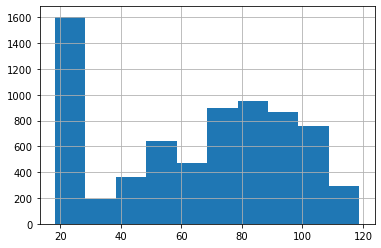

In [30]:
df['MonthlyCharges'].hist()

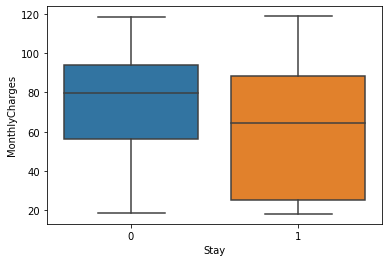

In [31]:
sns.boxplot (data = df, x = 'Stay', y = 'MonthlyCharges')

In [32]:
df.loc[df['TotalCharges'] == " "]

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay
488,Female,0,Yes,Yes,0,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,1
753,Male,0,No,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,1
936,Female,0,Yes,Yes,0,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,1
1082,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,1
1340,Female,0,Yes,Yes,0,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,1
3331,Male,0,Yes,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,1
3826,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,1
4380,Female,0,Yes,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,1
5218,Male,0,Yes,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,1
6670,Female,0,Yes,Yes,0,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,1


Some of the records has Total Charges is eqaul to empty string. WE can see that all of these customers have tenure is equal to 0. So, we can assume that Total Charges is 0. Replace them

In [33]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', '0.00')

In [34]:
len(df.loc[df['TotalCharges'] == " "])

0

In [35]:
df['TotalCharges'] = df['TotalCharges'].apply(pd.to_numeric)

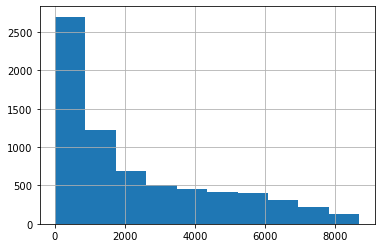

In [36]:
df['TotalCharges'].hist()

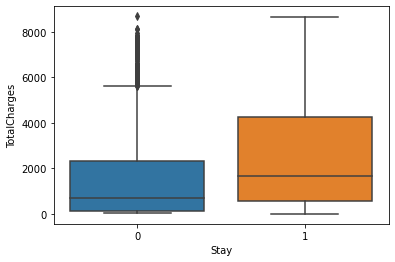

In [37]:
sns.boxplot (data = df, x = 'Stay', y = 'TotalCharges')

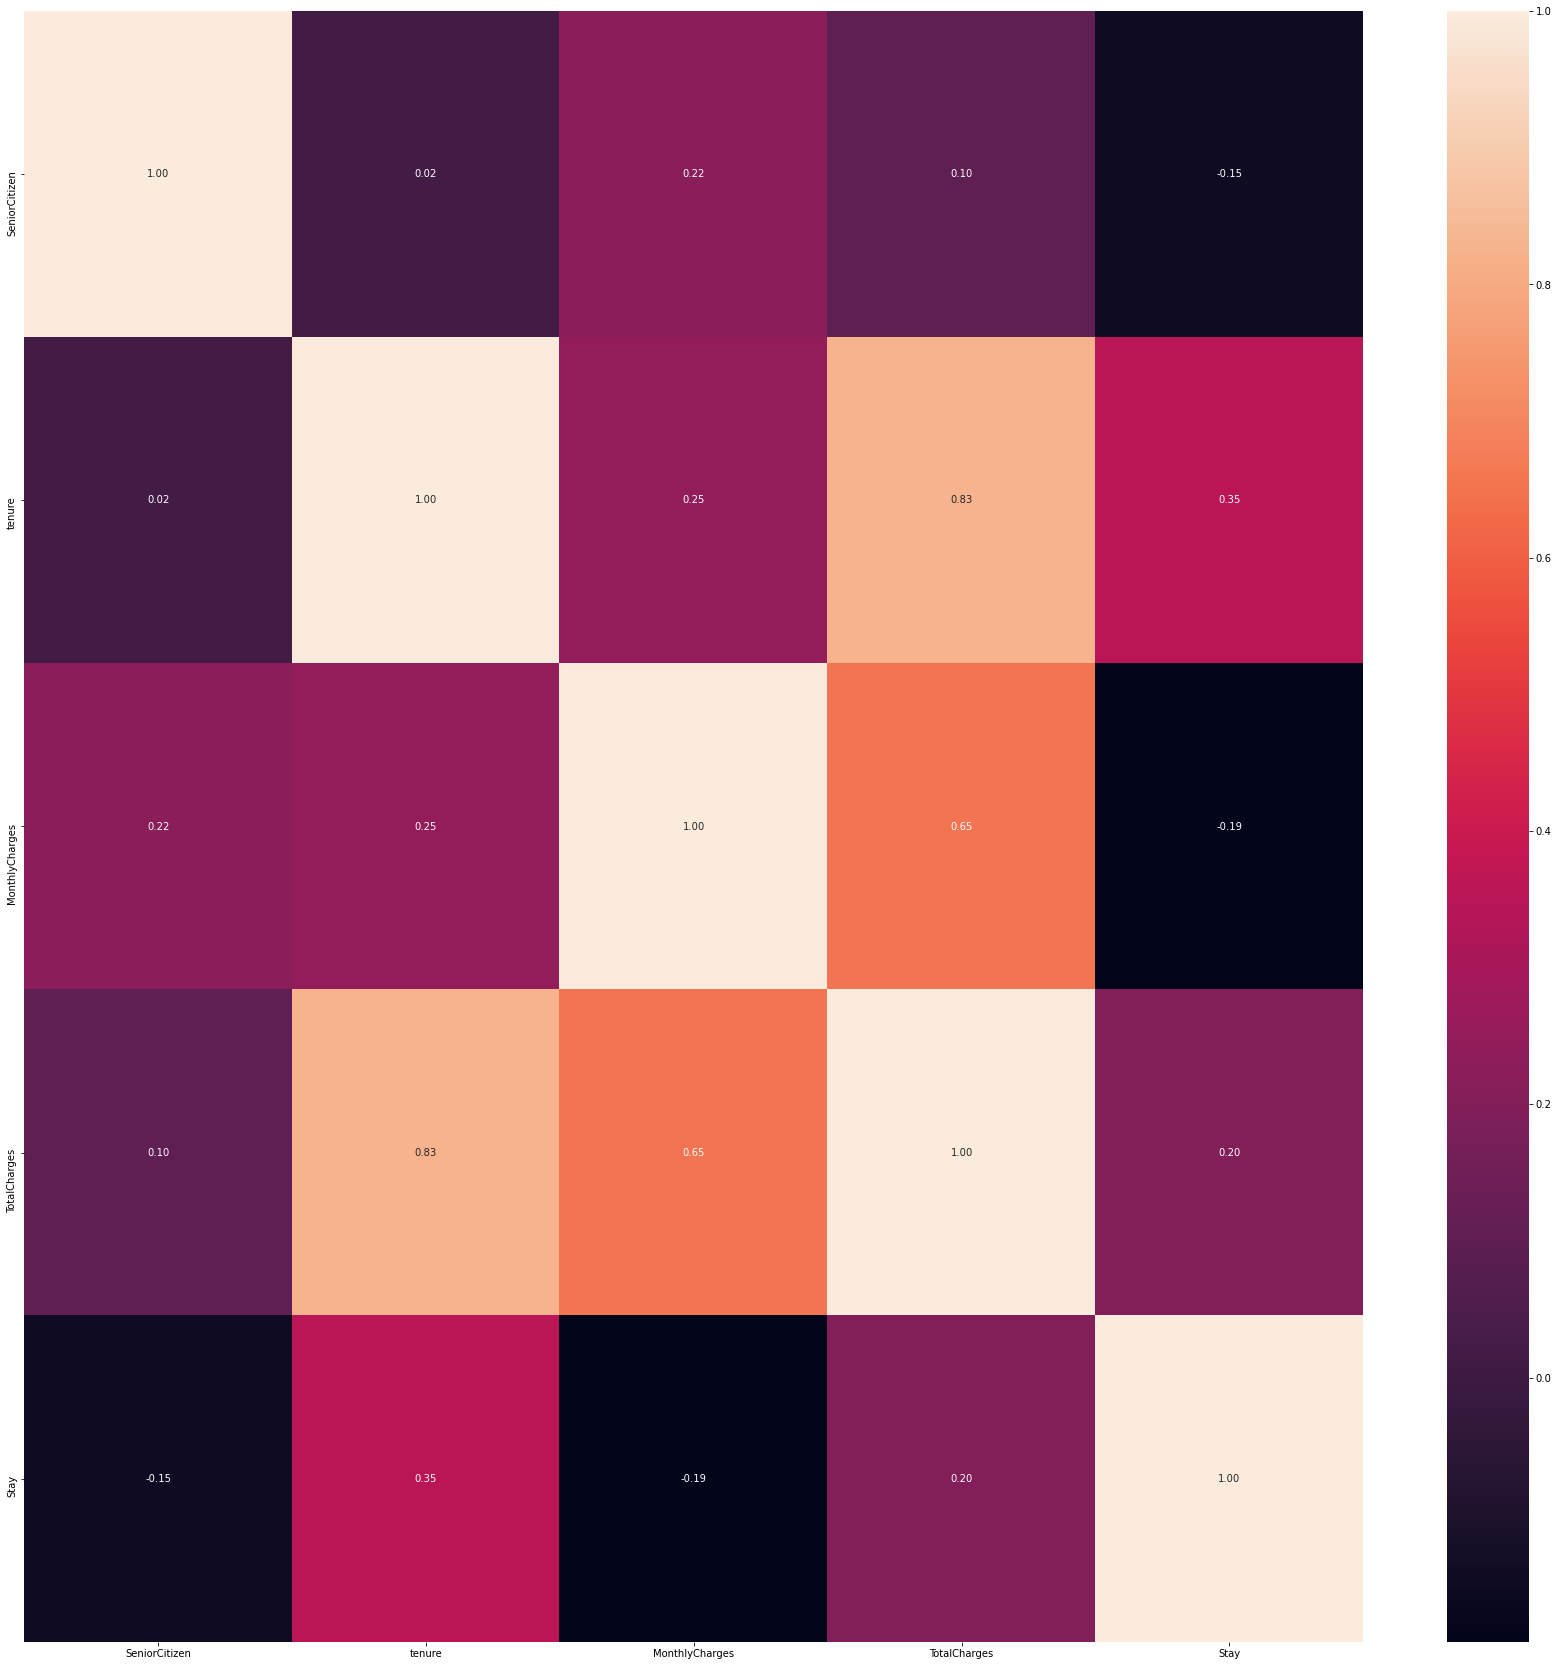

In [38]:
import matplotlib.pyplot as plt
corr = df.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, fmt='.2f')

C:\Users\kogti\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


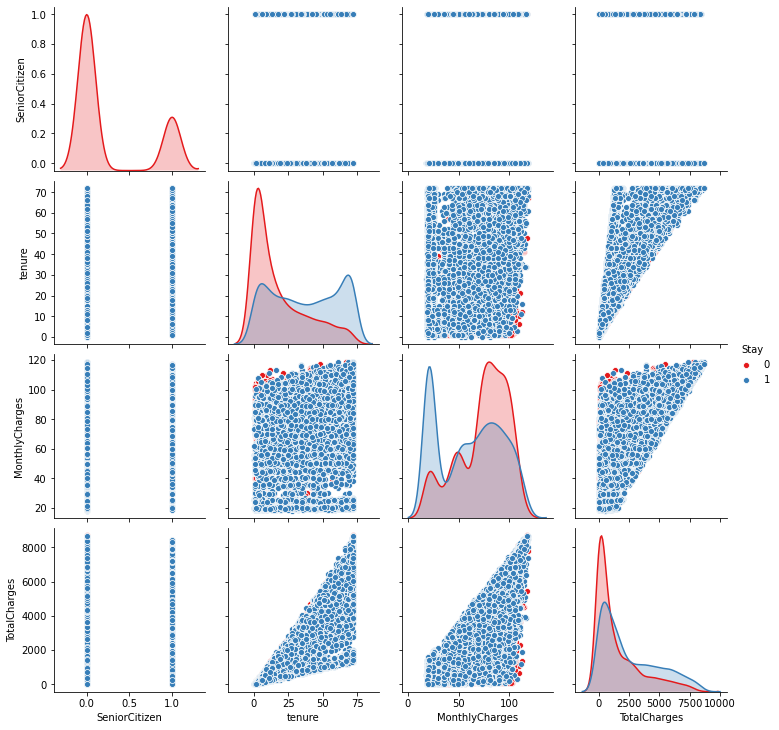

In [39]:
sns.pairplot(df, hue='Stay', palette='Set1')

It seems that all features are (smaller of higher) important for us except of gender, multiple Lines, Streaming Tv, Streaming Movies

## Feature preprocessing

In [40]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay
0,Female,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,1
1,Male,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,1
2,Male,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0
3,Male,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,1
4,Female,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0


In [41]:
not_important_features = []
not_very_important_features = []
important_features = []
very_important_features = []
continuous_features = []

##### Gender

Let's remove gender column because it has no importance, there is no difference between male customers and female ones, both of them have almost equal chances to stay as a customer

In [42]:
df['IsMale'] = df['gender'].map({'Female': 0, 'Male': 1})
df.drop(['gender'], axis = 1, inplace = True)
not_important_features.append('gender')
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,1,0
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,1,1
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,1
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,1,1
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0


##### SeniorCitizen

It seems that everything is okay with this feature

In [43]:
important_features.append('SeniorCitizen')

##### Partner

This is a binary variable. Just transform from {Yes, No} to {1, 0}

In [44]:
df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})

In [45]:
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale
0,0,1,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,1,0
1,0,0,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,1,1
2,0,0,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,1
3,0,0,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,1,1
4,0,0,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0


In [46]:
important_features = ['SeniorCitizen']

##### Dependents

The same as above

In [47]:
df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})

In [48]:
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale
0,0,1,0,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,1,0
1,0,0,0,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,1,1
2,0,0,0,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,1
3,0,0,0,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,1,1
4,0,0,0,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0


In [49]:
important_features = ['Dependents']

##### Tenure

This is continuous variable. We can scale it now, but lets try different scalers later. Just leave it as is

In [50]:
very_important_features.append('tenure')
continuous_features.append('tenure')

##### MultipleLines

Separate this feature into two parts: MultipleLines and SingleLine. If both of them are equal to 0 it means no Phone Service

In [51]:
df['SingleLine'] = df['MultipleLines'] == 'No'
df['Multiple_Lines'] = df['MultipleLines'] == 'Yes'
df['MultipleLines'] = df['Multiple_Lines']
df.drop(['Multiple_Lines'], axis = 1, inplace = True)
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine
0,0,1,0,1,False,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,False
1,0,0,0,34,False,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,1,1,True
2,0,0,0,2,False,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,1,True
3,0,0,0,45,False,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,1,1,False
4,0,0,0,2,False,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,True


In [52]:
not_very_important_features.append('MultipleLines')
not_very_important_features.append('SingleLine')

In [53]:
df['SingleLine'] = df['SingleLine'].map({False:0, True:1})
df['MultipleLines'] = df['MultipleLines'].map({False:0, True:1})
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine
0,0,1,0,1,0,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,0
1,0,0,0,34,0,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,1,1,1
2,0,0,0,2,0,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,1,1
3,0,0,0,45,0,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,1,1,0
4,0,0,0,2,0,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,1


##### InternetService

In [54]:
df['OnlineService'] = df['InternetService'] != 'No'
df["DSL"] = df["InternetService"] == "DSL"
df['OnlineService'] = df['OnlineService'].map({True: 1, False: 0})
df["DSL"] = df["DSL"].map({True: 1, False: 0})
df.drop(['InternetService'], axis = 1, inplace = True)
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine,OnlineService,DSL
0,0,1,0,1,0,No,Yes,No,No,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,0,1,1
1,0,0,0,34,0,Yes,No,Yes,No,No,...,One year,No,Mailed check,56.95,1889.50,1,1,1,1,1
2,0,0,0,2,0,Yes,Yes,No,No,No,...,Month-to-month,Yes,Mailed check,53.85,108.15,0,1,1,1,1
3,0,0,0,45,0,Yes,No,Yes,Yes,No,...,One year,No,Bank transfer (automatic),42.30,1840.75,1,1,0,1,1
4,0,0,0,2,0,No,No,No,No,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,1,1,0


In [55]:
important_features.append('OnlineService')
important_features.append('DSL')

In [56]:
important_features

['Dependents', 'OnlineService', 'DSL']

##### OnlineSecurity

Because we already have the column corresponds to presence of internet service, we can ignore 'no internet service' here

In [57]:
df['OnlineSecurity'] = df['OnlineSecurity'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine,OnlineService,DSL
0,0,1,0,1,0,0,Yes,No,No,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,0,1,1
1,0,0,0,34,0,1,No,Yes,No,No,...,One year,No,Mailed check,56.95,1889.50,1,1,1,1,1
2,0,0,0,2,0,1,Yes,No,No,No,...,Month-to-month,Yes,Mailed check,53.85,108.15,0,1,1,1,1
3,0,0,0,45,0,1,No,Yes,Yes,No,...,One year,No,Bank transfer (automatic),42.30,1840.75,1,1,0,1,1
4,0,0,0,2,0,0,No,No,No,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,1,1,0


In [58]:
very_important_features.append('OnlineSecurity')

##### OnlineBackup

The same as the above one

In [59]:
df['OnlineBackup'] = df['OnlineBackup'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine,OnlineService,DSL
0,0,1,0,1,0,0,1,No,No,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,0,1,1
1,0,0,0,34,0,1,0,Yes,No,No,...,One year,No,Mailed check,56.95,1889.50,1,1,1,1,1
2,0,0,0,2,0,1,1,No,No,No,...,Month-to-month,Yes,Mailed check,53.85,108.15,0,1,1,1,1
3,0,0,0,45,0,1,0,Yes,Yes,No,...,One year,No,Bank transfer (automatic),42.30,1840.75,1,1,0,1,1
4,0,0,0,2,0,0,0,No,No,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,1,1,0


In [60]:
important_features.append('OnlineBackup')

##### DeviceProtection

The same as the above one

In [61]:
df['DeviceProtection'] = df['DeviceProtection'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine,OnlineService,DSL
0,0,1,0,1,0,0,1,0,No,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,0,1,1
1,0,0,0,34,0,1,0,1,No,No,...,One year,No,Mailed check,56.95,1889.50,1,1,1,1,1
2,0,0,0,2,0,1,1,0,No,No,...,Month-to-month,Yes,Mailed check,53.85,108.15,0,1,1,1,1
3,0,0,0,45,0,1,0,1,Yes,No,...,One year,No,Bank transfer (automatic),42.30,1840.75,1,1,0,1,1
4,0,0,0,2,0,0,0,0,No,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,1,1,0


In [62]:
important_features.append('DeviceProtection')

##### TechSupport

The same as the above one

In [63]:
df['TechSupport'] = df['TechSupport'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine,OnlineService,DSL
0,0,1,0,1,0,0,1,0,0,No,...,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,0,1,1
1,0,0,0,34,0,1,0,1,0,No,...,One year,No,Mailed check,56.95,1889.50,1,1,1,1,1
2,0,0,0,2,0,1,1,0,0,No,...,Month-to-month,Yes,Mailed check,53.85,108.15,0,1,1,1,1
3,0,0,0,45,0,1,0,1,1,No,...,One year,No,Bank transfer (automatic),42.30,1840.75,1,1,0,1,1
4,0,0,0,2,0,0,0,0,0,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,1,1,0


In [64]:
very_important_features.append('TechSupport')

##### StreamingTV

The same as the above one

In [65]:
df['StreamingTV'] = df['StreamingTV'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine,OnlineService,DSL
0,0,1,0,1,0,0,1,0,0,0,...,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,0,1,1
1,0,0,0,34,0,1,0,1,0,0,...,One year,No,Mailed check,56.95,1889.50,1,1,1,1,1
2,0,0,0,2,0,1,1,0,0,0,...,Month-to-month,Yes,Mailed check,53.85,108.15,0,1,1,1,1
3,0,0,0,45,0,1,0,1,1,0,...,One year,No,Bank transfer (automatic),42.30,1840.75,1,1,0,1,1
4,0,0,0,2,0,0,0,0,0,0,...,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,1,1,0


In [66]:
not_very_important_features.append('StreamingTV')

##### StreamingMovies

The same as the above one

In [67]:
df['StreamingMovies'] = df['StreamingMovies'].map({'No': 0, 'Yes': 1, 'No internet service': 0})
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine,OnlineService,DSL
0,0,1,0,1,0,0,1,0,0,0,...,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,0,1,1
1,0,0,0,34,0,1,0,1,0,0,...,One year,No,Mailed check,56.95,1889.50,1,1,1,1,1
2,0,0,0,2,0,1,1,0,0,0,...,Month-to-month,Yes,Mailed check,53.85,108.15,0,1,1,1,1
3,0,0,0,45,0,1,0,1,1,0,...,One year,No,Bank transfer (automatic),42.30,1840.75,1,1,0,1,1
4,0,0,0,2,0,0,0,0,0,0,...,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,1,1,0


In [68]:
not_very_important_features.append('StreamingMovies')

##### Contract

In [69]:
contract_types = pd.get_dummies(df['Contract'])    
contract_types

,Month-to-month,One year,Two year
0,1,0,0
1,0,1,0
2,1,0,0
3,0,1,0
4,1,0,0
...,...,...,...
7038,0,1,0
7039,0,1,0
7040,1,0,0
7041,1,0,0


In [70]:
df = pd.concat([df, contract_types], axis = 1)

In [71]:
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine,OnlineService,DSL,Month-to-month,One year,Two year
0,0,1,0,1,0,0,1,0,0,0,...,29.85,29.85,1,0,0,1,1,1,0,0
1,0,0,0,34,0,1,0,1,0,0,...,56.95,1889.50,1,1,1,1,1,0,1,0
2,0,0,0,2,0,1,1,0,0,0,...,53.85,108.15,0,1,1,1,1,1,0,0
3,0,0,0,45,0,1,0,1,1,0,...,42.30,1840.75,1,1,0,1,1,0,1,0
4,0,0,0,2,0,0,0,0,0,0,...,70.70,151.65,0,0,1,1,0,1,0,0


In [72]:
df.drop(['Contract', 'Month-to-month'], axis = 1, inplace = True)
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine,OnlineService,DSL,One year,Two year
0,0,1,0,1,0,0,1,0,0,0,...,Electronic check,29.85,29.85,1,0,0,1,1,0,0
1,0,0,0,34,0,1,0,1,0,0,...,Mailed check,56.95,1889.50,1,1,1,1,1,1,0
2,0,0,0,2,0,1,1,0,0,0,...,Mailed check,53.85,108.15,0,1,1,1,1,0,0
3,0,0,0,45,0,1,0,1,1,0,...,Bank transfer (automatic),42.30,1840.75,1,1,0,1,1,1,0
4,0,0,0,2,0,0,0,0,0,0,...,Electronic check,70.70,151.65,0,0,1,1,0,0,0


In [73]:
very_important_features.append('One year')
very_important_features.append('Two year')

We removed Month-to-Month because it contains over information. If a customer has no one year contract and no two year contract it means the customer has month-to-month contract

##### PaperlessBilling

This is boolean variable

In [74]:
df['PaperlessBilling'] = df['PaperlessBilling'].map({"Yes": 1, "No": 0})
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaymentMethod,MonthlyCharges,TotalCharges,Stay,IsMale,SingleLine,OnlineService,DSL,One year,Two year
0,0,1,0,1,0,0,1,0,0,0,...,Electronic check,29.85,29.85,1,0,0,1,1,0,0
1,0,0,0,34,0,1,0,1,0,0,...,Mailed check,56.95,1889.50,1,1,1,1,1,1,0
2,0,0,0,2,0,1,1,0,0,0,...,Mailed check,53.85,108.15,0,1,1,1,1,0,0
3,0,0,0,45,0,1,0,1,1,0,...,Bank transfer (automatic),42.30,1840.75,1,1,0,1,1,1,0
4,0,0,0,2,0,0,0,0,0,0,...,Electronic check,70.70,151.65,0,0,1,1,0,0,0


In [75]:
important_features.append('PaperlessBilling')

##### PaymentMethod

In [76]:
payment_methods = pd.get_dummies(df['PaymentMethod'])
payment_methods

,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,0,0,1,0
1,0,0,0,1
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0
...,...,...,...,...
7038,0,0,0,1
7039,0,1,0,0
7040,0,0,1,0
7041,0,0,0,1


In [77]:
df = pd.concat([df, payment_methods], axis = 1)
df.drop(['PaymentMethod'], axis = 1 , inplace = True)
df.head(5)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,IsMale,SingleLine,OnlineService,DSL,One year,Two year,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
0,0,1,0,1,0,0,1,0,0,0,...,0,0,1,1,0,0,0,0,1,0
1,0,0,0,34,0,1,0,1,0,0,...,1,1,1,1,1,0,0,0,0,1
2,0,0,0,2,0,1,1,0,0,0,...,1,1,1,1,0,0,0,0,0,1
3,0,0,0,45,0,1,0,1,1,0,...,1,0,1,1,1,0,1,0,0,0
4,0,0,0,2,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0


In [78]:
very_important_features.append('Electronic check')
not_very_important_features.append('Bank transfer (automatic)')
not_very_important_features.append('Credit card (automatic)')
not_very_important_features.append('Mailed check')

##### MonthlyCharges

In [79]:
important_features.append('MonthlyCharges')

In [80]:
continuous_features.append('MonthlyCharges')

##### TotalCharges

In [81]:
important_features.append('TotalCharges')
continuous_features.append('TotalCharges')

##### Train - Test split

In [82]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop(['Stay'], axis=1), df['Stay'], test_size = 0.3 , random_state = 18)

## Gradient Boosting

In [83]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [84]:
est = GradientBoostingClassifier()
est.fit(x_train, y_train)
pred = est.predict(x_test)
print ("Accuracy Score: " + str(accuracy_score(pred, y_test)) + 
        ", Precision Score: " + str(precision_score(pred, y_test)) +
        ", Recall Score: " + str(recall_score(pred, y_test)) + 
        ", F1 Score: " + str(f1_score(pred, y_test)))

Accuracy Score: 0.8069096071935636, Precision Score: 0.8976478067387158, Recall Score: 0.8511151295961422, F1 Score: 0.8737623762376238


In [85]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)
print ("Accuracy Score: " + str(accuracy_score(pred, y_test)) + 
        ", Precision Score: " + str(precision_score(pred, y_test)) +
        ", Recall Score: " + str(recall_score(pred, y_test)) + 
        ", F1 Score: " + str(f1_score(pred, y_test)))

Accuracy Score: 0.7846663511594889, Precision Score: 0.8677685950413223, Recall Score: 0.8467741935483871, F1 Score: 0.8571428571428572


In [86]:
cat = CatBoostClassifier()
cat.fit(x_train, y_train)
pred = cat.predict(x_test)
print ("Accuracy Score: " + str(accuracy_score(pred, y_test)) + 
        ", Precision Score: " + str(precision_score(pred, y_test)) +
        ", Recall Score: " + str(recall_score(pred, y_test)) + 
        ", F1 Score: " + str(f1_score(pred, y_test)))

Learning rate set to 0.02036
0:	learn: 0.6794656	total: 161ms	remaining: 2m 40s
1:	learn: 0.6673038	total: 168ms	remaining: 1m 23s
2:	learn: 0.6554669	total: 177ms	remaining: 58.8s
3:	learn: 0.6433028	total: 184ms	remaining: 45.9s
4:	learn: 0.6320774	total: 190ms	remaining: 37.7s
5:	learn: 0.6219999	total: 194ms	remaining: 32.1s
6:	learn: 0.6124978	total: 198ms	remaining: 28.1s
7:	learn: 0.6024982	total: 201ms	remaining: 24.9s
8:	learn: 0.5943283	total: 204ms	remaining: 22.5s
9:	learn: 0.5857857	total: 207ms	remaining: 20.5s
10:	learn: 0.5780970	total: 211ms	remaining: 18.9s
11:	learn: 0.5719372	total: 214ms	remaining: 17.7s
12:	learn: 0.5649279	total: 218ms	remaining: 16.5s
13:	learn: 0.5582030	total: 221ms	remaining: 15.6s
14:	learn: 0.5517932	total: 224ms	remaining: 14.7s
15:	learn: 0.5457555	total: 230ms	remaining: 14.1s
16:	learn: 0.5405908	total: 245ms	remaining: 14.2s
17:	learn: 0.5347056	total: 248ms	remaining: 13.6s
18:	learn: 0.5300905	total: 261ms	remaining: 13.5s
19:	learn:

207:	learn: 0.3910715	total: 1.08s	remaining: 4.13s
208:	learn: 0.3910431	total: 1.09s	remaining: 4.11s
209:	learn: 0.3908477	total: 1.09s	remaining: 4.1s
210:	learn: 0.3905589	total: 1.09s	remaining: 4.08s
211:	learn: 0.3903570	total: 1.09s	remaining: 4.07s
212:	learn: 0.3902443	total: 1.1s	remaining: 4.06s
213:	learn: 0.3901216	total: 1.1s	remaining: 4.05s
214:	learn: 0.3899460	total: 1.11s	remaining: 4.04s
215:	learn: 0.3898354	total: 1.11s	remaining: 4.03s
216:	learn: 0.3897391	total: 1.11s	remaining: 4.02s
217:	learn: 0.3895481	total: 1.12s	remaining: 4.01s
218:	learn: 0.3894116	total: 1.12s	remaining: 3.99s
219:	learn: 0.3892492	total: 1.12s	remaining: 3.98s
220:	learn: 0.3891063	total: 1.13s	remaining: 3.97s
221:	learn: 0.3890112	total: 1.13s	remaining: 3.96s
222:	learn: 0.3888416	total: 1.13s	remaining: 3.95s
223:	learn: 0.3887567	total: 1.14s	remaining: 3.94s
224:	learn: 0.3886523	total: 1.14s	remaining: 3.92s
225:	learn: 0.3884798	total: 1.14s	remaining: 3.91s
226:	learn: 0.3

385:	learn: 0.3677723	total: 1.8s	remaining: 2.87s
386:	learn: 0.3676103	total: 1.8s	remaining: 2.86s
387:	learn: 0.3675283	total: 1.81s	remaining: 2.85s
388:	learn: 0.3674544	total: 1.81s	remaining: 2.85s
389:	learn: 0.3673232	total: 1.81s	remaining: 2.84s
390:	learn: 0.3671006	total: 1.83s	remaining: 2.86s
391:	learn: 0.3668368	total: 1.84s	remaining: 2.85s
392:	learn: 0.3667093	total: 1.84s	remaining: 2.84s
393:	learn: 0.3665890	total: 1.84s	remaining: 2.83s
394:	learn: 0.3664919	total: 1.84s	remaining: 2.83s
395:	learn: 0.3664010	total: 1.85s	remaining: 2.82s
396:	learn: 0.3662569	total: 1.85s	remaining: 2.81s
397:	learn: 0.3660658	total: 1.85s	remaining: 2.81s
398:	learn: 0.3659515	total: 1.86s	remaining: 2.8s
399:	learn: 0.3657759	total: 1.86s	remaining: 2.79s
400:	learn: 0.3656344	total: 1.86s	remaining: 2.78s
401:	learn: 0.3655149	total: 1.87s	remaining: 2.78s
402:	learn: 0.3653851	total: 1.87s	remaining: 2.77s
403:	learn: 0.3651577	total: 1.87s	remaining: 2.76s
404:	learn: 0.3

546:	learn: 0.3478852	total: 2.54s	remaining: 2.11s
547:	learn: 0.3478359	total: 2.55s	remaining: 2.1s
548:	learn: 0.3476828	total: 2.55s	remaining: 2.1s
549:	learn: 0.3475795	total: 2.55s	remaining: 2.09s
550:	learn: 0.3474461	total: 2.56s	remaining: 2.08s
551:	learn: 0.3473206	total: 2.56s	remaining: 2.08s
552:	learn: 0.3471843	total: 2.56s	remaining: 2.07s
553:	learn: 0.3471220	total: 2.57s	remaining: 2.07s
554:	learn: 0.3470007	total: 2.59s	remaining: 2.07s
555:	learn: 0.3469129	total: 2.59s	remaining: 2.07s
556:	learn: 0.3467453	total: 2.6s	remaining: 2.07s
557:	learn: 0.3466314	total: 2.6s	remaining: 2.06s
558:	learn: 0.3464915	total: 2.61s	remaining: 2.06s
559:	learn: 0.3463681	total: 2.61s	remaining: 2.05s
560:	learn: 0.3462529	total: 2.61s	remaining: 2.04s
561:	learn: 0.3461417	total: 2.62s	remaining: 2.04s
562:	learn: 0.3460400	total: 2.62s	remaining: 2.03s
563:	learn: 0.3459409	total: 2.62s	remaining: 2.03s
564:	learn: 0.3458056	total: 2.63s	remaining: 2.02s
565:	learn: 0.34

705:	learn: 0.3308349	total: 3.26s	remaining: 1.36s
706:	learn: 0.3307660	total: 3.27s	remaining: 1.35s
707:	learn: 0.3306638	total: 3.27s	remaining: 1.35s
708:	learn: 0.3305804	total: 3.27s	remaining: 1.34s
709:	learn: 0.3304420	total: 3.28s	remaining: 1.34s
710:	learn: 0.3304090	total: 3.28s	remaining: 1.33s
711:	learn: 0.3303310	total: 3.29s	remaining: 1.33s
712:	learn: 0.3302760	total: 3.29s	remaining: 1.32s
713:	learn: 0.3301136	total: 3.29s	remaining: 1.32s
714:	learn: 0.3300091	total: 3.3s	remaining: 1.31s
715:	learn: 0.3298929	total: 3.3s	remaining: 1.31s
716:	learn: 0.3297168	total: 3.3s	remaining: 1.3s
717:	learn: 0.3295984	total: 3.31s	remaining: 1.3s
718:	learn: 0.3294885	total: 3.31s	remaining: 1.29s
719:	learn: 0.3293989	total: 3.31s	remaining: 1.29s
720:	learn: 0.3293247	total: 3.31s	remaining: 1.28s
721:	learn: 0.3292931	total: 3.32s	remaining: 1.28s
722:	learn: 0.3291620	total: 3.32s	remaining: 1.27s
723:	learn: 0.3290971	total: 3.32s	remaining: 1.27s
724:	learn: 0.328

898:	learn: 0.3130700	total: 3.98s	remaining: 448ms
899:	learn: 0.3129976	total: 3.99s	remaining: 443ms
900:	learn: 0.3129122	total: 3.99s	remaining: 438ms
901:	learn: 0.3128585	total: 3.99s	remaining: 434ms
902:	learn: 0.3127535	total: 4s	remaining: 429ms
903:	learn: 0.3126703	total: 4s	remaining: 425ms
904:	learn: 0.3126261	total: 4s	remaining: 420ms
905:	learn: 0.3125559	total: 4.01s	remaining: 416ms
906:	learn: 0.3124752	total: 4.01s	remaining: 411ms
907:	learn: 0.3123657	total: 4.01s	remaining: 407ms
908:	learn: 0.3122680	total: 4.02s	remaining: 402ms
909:	learn: 0.3122487	total: 4.02s	remaining: 398ms
910:	learn: 0.3121620	total: 4.03s	remaining: 393ms
911:	learn: 0.3120989	total: 4.03s	remaining: 389ms
912:	learn: 0.3120113	total: 4.04s	remaining: 385ms
913:	learn: 0.3118885	total: 4.05s	remaining: 381ms
914:	learn: 0.3118128	total: 4.06s	remaining: 377ms
915:	learn: 0.3117807	total: 4.06s	remaining: 372ms
916:	learn: 0.3117177	total: 4.06s	remaining: 368ms
917:	learn: 0.3116325

In [87]:
lgbm = LGBMClassifier()
lgbm.fit(x_train, y_train)
pred = lgbm.predict(x_test)
print ("Accuracy Score: " + str(accuracy_score(pred, y_test)) + 
        ", Precision Score: " + str(precision_score(pred, y_test)) +
        ", Recall Score: " + str(recall_score(pred, y_test)) + 
        ", F1 Score: " + str(f1_score(pred, y_test)))

Accuracy Score: 0.7993374349266446, Precision Score: 0.8862047043865225, Recall Score: 0.8505186089078707, F1 Score: 0.8679950186799502


We will compare accuracy, the fourth place is XGBClassifier with result 0.7847; the third place is LGBMClassifier with result 0.7993; the second place is CatBoostClassifier with result 0.8003 and the first place is GradientBoostingClassifier with result 0.8069

##### Work with features

In [88]:
def Execute_Tests (x_train, y_train, x_test, y_test):
    est = GradientBoostingClassifier()
    est.fit(x_train, y_train)
    pred_est = est.predict(x_test)
    xgb = XGBClassifier()
    xgb.fit(x_train, y_train)
    pred_xgb = xgb.predict(x_test)
    cat = CatBoostClassifier(logging_level='Silent')
    cat.fit(x_train, y_train)
    pred_cat = cat.predict(x_test)
    lgbm = LGBMClassifier()
    lgbm.fit(x_train, y_train)
    pred_lgbm = lgbm.predict(x_test)
    result = []
    result.append ("Accuracy EST: " + str(accuracy_score(pred_est, y_test)))
    result.append ("Accuracy XGB: " + str(accuracy_score(pred_xgb, y_test)))
    result.append ("Accuracy CAT: " + str(accuracy_score(pred_cat, y_test)))
    result.append ("Accuracy LGBM: " + str(accuracy_score(pred_lgbm, y_test)))
    
    return result

In [89]:
print(Execute_Tests(x_train, y_train, x_test, y_test))

['Accuracy EST: 0.8069096071935636', 'Accuracy XGB: 0.7846663511594889', 'Accuracy CAT: 0.8002839564600095', 'Accuracy LGBM: 0.7993374349266446']


In [90]:
df_cont = df[continuous_features]
df_cont

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65
...,...,...,...
7038,24,84.80,1990.50
7039,72,103.20,7362.90
7040,11,29.60,346.45
7041,4,74.40,306.60


In [91]:
from sklearn.preprocessing import StandardScaler

In [92]:
scaler = StandardScaler()
x_train_copy = x_train.copy()
x_test_copy = x_test.copy()
x_train_copy[continuous_features] = scaler.fit_transform(x_train[continuous_features])
x_test_copy[continuous_features] = scaler.fit_transform(x_test[continuous_features])

In [93]:
print(Execute_Tests(x_train_copy, y_train, x_test_copy, y_test))

['Accuracy EST: 0.812588736393753', 'Accuracy XGB: 0.7856128726928537', 'Accuracy CAT: 0.8054898248935163', 'Accuracy LGBM: 0.7969711310932324']


In [94]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
x_train_robust = x_train.copy()
x_test_robust = x_test.copy()
x_train_robust[continuous_features] = scaler.fit_transform(x_train[continuous_features])
x_test_robust[continuous_features] = scaler.fit_transform(x_test[continuous_features])
print(Execute_Tests(x_train_robust, y_train, x_test_robust, y_test))

['Accuracy EST: 0.8050165641268339', 'Accuracy XGB: 0.7870326549929011', 'Accuracy CAT: 0.8035967818267865', 'Accuracy LGBM: 0.7950780880265026']


Standart Scaler has the best result: 0.8126. Keep it

In [95]:
x_train = x_train_copy
x_test = x_test_copy

In [96]:
level2_importance = np.concatenate((important_features, very_important_features, not_very_important_features), axis=0)
level2_importance

array(['Dependents', 'OnlineService', 'DSL', 'OnlineBackup',
       'DeviceProtection', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'tenure', 'OnlineSecurity', 'TechSupport',
       'One year', 'Two year', 'Electronic check', 'MultipleLines',
       'SingleLine', 'StreamingTV', 'StreamingMovies',
       'Bank transfer (automatic)', 'Credit card (automatic)',
       'Mailed check'], dtype='<U25')

In [97]:
print(Execute_Tests(x_train[level2_importance], y_train, x_test[level2_importance], y_test))

['Accuracy EST: 0.8097491717936584', 'Accuracy XGB: 0.7856128726928537', 'Accuracy CAT: 0.8026502602934217', 'Accuracy LGBM: 0.8026502602934217']


In [98]:
level3_importance = np.concatenate((important_features, very_important_features), axis=0)
level3_importance

array(['Dependents', 'OnlineService', 'DSL', 'OnlineBackup',
       'DeviceProtection', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'tenure', 'OnlineSecurity', 'TechSupport',
       'One year', 'Two year', 'Electronic check'], dtype='<U16')

In [99]:
print(Execute_Tests(x_train[level3_importance], y_train, x_test[level3_importance], y_test))

['Accuracy EST: 0.8092759110269758', 'Accuracy XGB: 0.79649787032655', 'Accuracy CAT: 0.8017037387600567', 'Accuracy LGBM: 0.8021769995267393']


In [100]:
level4_importance = very_important_features
level4_importance

['tenure',
 'OnlineSecurity',
 'TechSupport',
 'One year',
 'Two year',
 'Electronic check']

In [101]:
print(Execute_Tests(x_train[level4_importance], y_train, x_test[level4_importance], y_test))

['Accuracy EST: 0.7742546142924751', 'Accuracy XGB: 0.7605300520586843', 'Accuracy CAT: 0.767628963558921', 'Accuracy LGBM: 0.7685754850922859']


Our final data is all features scaled using Standart Scaler. The best result so far is 0.8126

## Cross validation of parameters

In [102]:
from sklearn.model_selection import RandomizedSearchCV
params = {'n_estimators': range(1,500), 'learning_rate':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35] , 'max_depth': range (1,10)}
est = GradientBoostingClassifier()
rand_search = RandomizedSearchCV(est, params, cv=5, scoring='accuracy')
rand_search.fit(x_train, y_train)
print ("Best estimators: " + str(rand_search.best_estimator_.n_estimators) + ", Best learning rate: " +
      str(rand_search.best_estimator_.learning_rate) + " , Best depth: " + str(rand_search.best_estimator_.max_depth))

Best estimators: 70, Best learning rate: 0.1 , Best depth: 4


In [103]:
est = GradientBoostingClassifier(n_estimators=179, learning_rate=0.25, max_depth=1)
est.fit(x_train, y_train)
pred = est.predict(x_test)
print("Final accuracy EST: " + str(accuracy_score(pred, y_test)))

Final accuracy EST: 0.8088026502602934


Cross-validation didn't help the final score for EST: 0.8126

In [104]:
params = {'n_estimators': range(1,500), 'learning_rate':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35] , 'max_depth': range (1,10)}
xgb = XGBClassifier()
rand_search = RandomizedSearchCV(xgb, params, cv=5, scoring='accuracy')
rand_search.fit(x_train, y_train)
print ("Best estimators: " + str(rand_search.best_estimator_.n_estimators) + ", Best learning rate: " +
      str(rand_search.best_estimator_.learning_rate) + " , Best depth: " + str(rand_search.best_estimator_.max_depth))

Best estimators: 332, Best learning rate: 0.15 , Best depth: 1


In [105]:
xgb = XGBClassifier(n_estimators=318, learning_rate=0.05, max_depth=1)
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)
print("Final accuracy XGB: " + str(accuracy_score(pred, y_test)))

Final accuracy XGB: 0.8111689540937056


The best score for XGB: 0.8112

In [111]:
params = {'n_estimators': range(1,500),'learning_rate':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35] , 'max_depth': range (1,10)}
lgbm = LGBMClassifier()
rand_search = RandomizedSearchCV(lgbm, params, cv=5, scoring='accuracy')
rand_search.fit(x_train, y_train)
print ("Best estimators: " + str(rand_search.best_estimator_.n_estimators) + ", Best learning rate: " +
      str(rand_search.best_estimator_.learning_rate) + " , Best depth: " + str(rand_search.best_estimator_.max_depth))

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

In [112]:
lgbm = LGBMClassifier(n_estimators=192, learning_rate=0.05, max_depth=5)
lgbm.fit(x_train, y_train)
pred = lgbm.predict(x_test)
print("Final accuracy LGBM: " + str(accuracy_score(pred, y_test)))

Final accuracy LGBM: 0.8050165641268339


The best score for LGBM is 0.805

In [140]:
params = {'learning_rate':[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}
cat = CatBoostClassifier(logging_level='Silent')
rand_search = RandomizedSearchCV(cat, params, cv=5, scoring='accuracy')
rand_search.fit(x_train, y_train)
print (str(rand_search.best_estimator_.learning_rate_))

C:\Users\kogti\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.05000000074505806


In [141]:
cat = CatBoostClassifier(learning_rate=0.05, logging_level='Silent')
cat.fit(x_train, y_train)
pred = cat.predict(x_test)
print("Final accuracy CAT: " + str(accuracy_score(pred, y_test)))

Final accuracy CAT: 0.7969711310932324


The best gradient boosting method is GradientBoostingClassifier with result 0.8126;
We used randomized search search CV, so if we run it again the result can be different